In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.utils.data
from torch.autograd import Variable

# Load the data

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


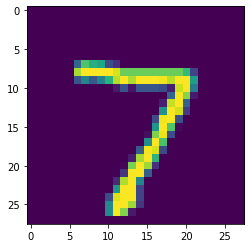

displaying a 7


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)


    plt.imshow(X[0][0].numpy())
    plt.show()
    print(f'displaying a {y[0]}')
    break

# Define the various dropout models


The models have 0.5, 0.25, and 0.75 dropout respectively.

# 0.5 Dropout

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class Dropout25CNN(nn.Module):
    def __init__(self):
        super(Dropout25CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=8)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=8)
        self.fc1 = nn.Linear(7*7*12, 30)
        self.fc2 = nn.Linear(30, 10)

        torch.nn.init.xavier_uniform(self.conv1.weight)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        torch.nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,7*7*12)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Dropout25CNN().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

Using cuda device


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


Dropout25CNN(
  (conv1): Conv2d(1, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=588, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)


Training loop is based on https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [5]:
train_losses = []
test_losses = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_losses.append(loss)

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    test_losses.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
loss: 2.382689  [    0/60000]
loss: 1.128252  [ 6400/60000]
loss: 0.724500  [12800/60000]
loss: 1.006782  [19200/60000]
loss: 0.891488  [25600/60000]
loss: 0.803339  [32000/60000]
loss: 0.662175  [38400/60000]
loss: 0.758593  [44800/60000]
loss: 0.591139  [51200/60000]
loss: 0.809071  [57600/60000]
Test Error: 
 Accuracy: 91.7%, Avg loss: 0.005199 

Epoch 2
-------------------------------
loss: 0.274990  [    0/60000]
loss: 0.307169  [ 6400/60000]
loss: 0.136891  [12800/60000]
loss: 0.087679  [19200/60000]
loss: 0.025755  [25600/60000]
loss: 0.085638  [32000/60000]
loss: 0.053568  [38400/60000]
loss: 0.055818  [44800/60000]
loss: 0.351037  [51200/60000]
loss: 0.145824  [57600/60000]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.001259 

Epoch 3
-------------------------------
loss: 0.041610  [    0/60000]
loss: 0.077494  [ 6400/60000]
loss: 0.087445  [12800/60000]
loss: 0.074140  [19200/60000]
loss: 0.006829  [25600/60000]
loss: 0.093120  [32000/600

Generate learning curves for the validation and training set. Discuss whether this base-
line system overfits, underfits or reasonably fits the validation data. Test this baseline system with
the testing data and report the accuracy and show a confusion matrix

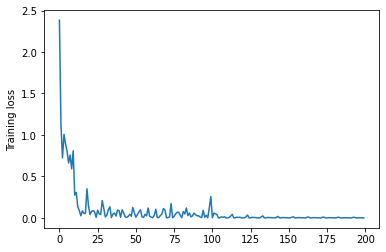

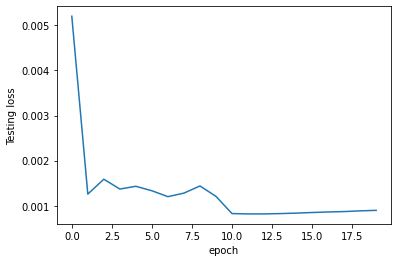

In [6]:
plt.plot(train_losses)
plt.ylabel('Training loss')
plt.show()

plt.plot(test_losses)
plt.ylabel('Testing loss')
plt.xlabel('epoch')
plt.show()

It looks like very good accuracy was achieved again, in around the same amount of epochs as the baseline.

# 0.25 dropout

Using cuda device
Dropout25CNN(
  (conv1): Conv2d(1, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=588, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)
Epoch 1
-------------------------------
loss: 2.329858  [    0/60000]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


loss: 0.970384  [ 6400/60000]
loss: 0.224771  [12800/60000]
loss: 0.531039  [19200/60000]
loss: 0.420779  [25600/60000]
loss: 0.230137  [32000/60000]
loss: 0.271350  [38400/60000]
loss: 0.220214  [44800/60000]
loss: 0.300332  [51200/60000]
loss: 0.279695  [57600/60000]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.002251 

Epoch 2
-------------------------------
loss: 0.069286  [    0/60000]
loss: 0.120680  [ 6400/60000]
loss: 0.132773  [12800/60000]
loss: 0.099062  [19200/60000]
loss: 0.014341  [25600/60000]
loss: 0.150558  [32000/60000]
loss: 0.078400  [38400/60000]
loss: 0.136474  [44800/60000]
loss: 0.137240  [51200/60000]
loss: 0.096976  [57600/60000]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.002429 

Epoch 3
-------------------------------
loss: 0.079091  [    0/60000]
loss: 0.168439  [ 6400/60000]
loss: 0.090556  [12800/60000]
loss: 0.256054  [19200/60000]
loss: 0.047760  [25600/60000]
loss: 0.052420  [32000/60000]
loss: 0.031763  [38400/60000]
loss: 0.060035  [44800/60000]
loss: 

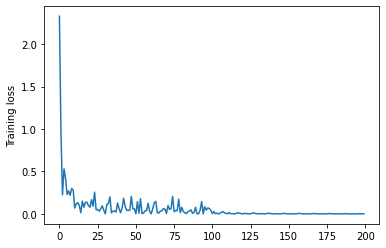

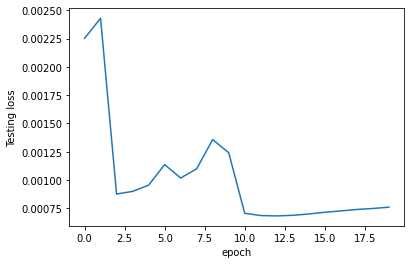

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class Dropout25CNN(nn.Module):
    def __init__(self):
        super(Dropout25CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=8)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=8)
        self.fc1 = nn.Linear(7*7*12, 30)
        self.fc2 = nn.Linear(30, 10)

        torch.nn.init.xavier_uniform(self.conv1.weight)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        torch.nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.25, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.25, training=self.training)
        x = x.view(-1,7*7*12)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Dropout25CNN().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

train_losses = []
test_losses = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_losses.append(loss)

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    test_losses.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
    scheduler.step()
print("Done!")

plt.plot(train_losses)
plt.ylabel('Training loss')
plt.show()

plt.plot(test_losses)
plt.ylabel('Testing loss')
plt.xlabel('epoch')
plt.show()

Even better accuracy was achieved, and this occured around the same number of epochs as the baseline/0.5 ones.

# 0.75 dropout

Using cuda device
Dropout25CNN(
  (conv1): Conv2d(1, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=588, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)
Epoch 1
-------------------------------
loss: 3.739778  [    0/60000]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


loss: 2.298024  [ 6400/60000]
loss: 2.316676  [12800/60000]
loss: 2.303651  [19200/60000]
loss: 2.309742  [25600/60000]
loss: 2.311028  [32000/60000]
loss: 2.298413  [38400/60000]
loss: 2.315494  [44800/60000]
loss: 2.303185  [51200/60000]
loss: 2.304006  [57600/60000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 0.036132 

Epoch 2
-------------------------------
loss: 2.301160  [    0/60000]
loss: 2.298001  [ 6400/60000]
loss: 2.316675  [12800/60000]
loss: 2.303651  [19200/60000]
loss: 2.309742  [25600/60000]
loss: 2.311028  [32000/60000]
loss: 2.298413  [38400/60000]
loss: 2.315494  [44800/60000]
loss: 2.303185  [51200/60000]
loss: 2.304006  [57600/60000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 0.036132 

Epoch 3
-------------------------------
loss: 2.301160  [    0/60000]
loss: 2.298001  [ 6400/60000]
loss: 2.316675  [12800/60000]
loss: 2.303651  [19200/60000]
loss: 2.309742  [25600/60000]
loss: 2.311028  [32000/60000]
loss: 2.298413  [38400/60000]
loss: 2.315494  [44800/60000]
loss: 

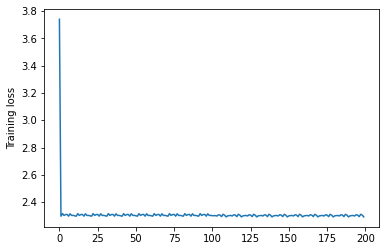

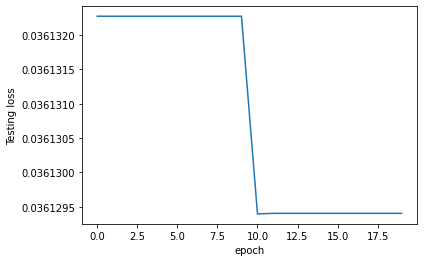

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class Dropout25CNN(nn.Module):
    def __init__(self):
        super(Dropout25CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=8)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=8)
        self.fc1 = nn.Linear(7*7*12, 30)
        self.fc2 = nn.Linear(30, 10)

        torch.nn.init.xavier_uniform(self.conv1.weight)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        torch.nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.75, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.75, training=self.training)
        x = x.view(-1,7*7*12)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.75, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Dropout25CNN().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

train_losses = []
test_losses = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_losses.append(loss)

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    test_losses.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
    scheduler.step()
print("Done!")

plt.plot(train_losses)
plt.ylabel('Training loss')
plt.show()

plt.plot(test_losses)
plt.ylabel('Testing loss')
plt.xlabel('epoch')
plt.show()

This didn't work well at all. Accuracy never got past around 11%.